## Arboles con datos reales

Normalmente crear un modelo de prediccion requiere los siguientes pasos:

- Exploracion de Datos
- Imputacion
- Encoder
- Entrenar
- Seleccionar variables
- Medir


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 1000)
%matplotlib inline

In [2]:
df = pd.read_excel("data/LendingClub_Kaggle.xlsx", sheet_name="Train")
df["is_test"] = 0
df_oob = pd.read_excel("data/LendingClub_Kaggle.xlsx", sheet_name="Test")
df["is_test"] = 1

In [3]:
df = pd.concat((df,df_oob), axis=0, ignore_index=True)

/Users/millenium/anaconda/envs/homework1/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [4]:
df.shape

(20000, 104)

In [5]:
df.head(10)

,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,application_type,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collection_recovery_fee,collections_12_mths_ex_med,delinq_2yrs,delinq_amnt,dti,earliest_cr_line,emp_length,emp_title,funded_amnt,funded_amnt_inv,grade,home_ownership,id,il_util,initial_list_status,inq_fi,inq_last_12m,inq_last_6mths,installment,int_rate,is_test,issue_d,last_credit_pull_d,last_pymnt_amnt,last_pymnt_d,loan_amnt,loan_status,max_bal_bc,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,month_issued,mort_acc,mths_since_rcnt_il,mths_since_recent_bc,mths_since_recent_inq,next_pymnt_d,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_acc_6m,open_il_12m,open_il_24m,open_il_6m,open_rv_12m,open_rv_24m,out_prncp,out_prncp_inv,pct_tl_nvr_dlq,percent_bc_gt_75,policy_code,pub_rec,pub_rec_bankruptcies,purpose,pymnt_plan,recoveries,revol_bal,revol_util,sub_grade,tax_liens,term,title,tot_coll_amt,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bal_il,total_bc_limit,total_cu_tl,total_il_high_credit_limit,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,verification_status,willGoBad,year_issued,zip_code
0,0,7,ID,76.0,107485.0,INDIVIDUAL,22520,800.0,81.0,0,0,0,1,0,16.31,1998-06-01,6 years,Shift Lead,6000,6000,C,MORTGAGE,1,84.0,w,0.0,6.0,2,199.26,11.99,1.0,2016-03-01,2017-03-01,199.26,2017-03-01,6000,Current,645.0,160.0,213,3,3,3,1,7.0,131.0,1.0,2017-04-01,0,1,8,2,3,8,8,11,7,11,NaN,0,0,6,11,1.0,1.0,2.0,2.0,4.0,4.0,4388.69,4388.69,82.0,100.0,1,3,0,medical,n,0,19426,76.0,C1,1,36 months,Medical expenses,0,247728,261202,22,47461,28035.0,800,3.0,33489,2187.86,2187.86,576.55,0.0,1611.31,25559,Verified,0.0,2016,834xx
1,0,3,CA,54.0,70000.0,INDIVIDUAL,4342,11850.0,54.2,0,0,0,0,0,13.82,2001-09-01,3 years,Communications Manager,14000,14000,A,RENT,2,61.0,w,0.0,1.0,0,432.22,6.99,1.0,2016-01-01,2017-03-01,432.22,2017-03-01,14000,Current,8036.0,141.0,172,11,11,1,1,32.0,11.0,11.0,2017-04-01,0,3,4,4,12,5,6,22,5,7,0.0,0,0,1,7,0.0,0.0,0.0,1.0,1.0,3.0,8900.34,8900.34,100.0,25.0,1,0,0,credit_card,n,0,14428,48.1,A3,0,36 months,Credit card refinancing,0,30397,56101,28,30397,15969.0,25900,3.0,26101,6045.64,6045.64,945.98,0.0,5099.66,30000,Not Verified,0.0,2016,953xx
2,0,6,VA,81.0,45000.0,INDIVIDUAL,4050,387.0,88.6,0,0,0,2,0,16.67,2012-08-01,1 year,Bartender,5000,5000,C,RENT,3,81.0,w,3.0,4.0,3,174.09,15.31,1.0,2016-03-01,2017-03-01,174.09,2017-03-01,5000,Current,2291.0,38.0,43,10,6,3,0,6.0,24.0,3.0,2017-04-01,0,3,5,3,3,8,5,5,5,12,0.0,0,0,3,12,2.0,2.0,4.0,7.0,1.0,2.0,3579.48,3579.48,84.6,66.7,1,0,0,other,n,0,3783,82.2,C5,0,36 months,Other,0,48598,59870,13,48598,44815.0,3400,1.0,55270,2080.57,2080.57,660.05,0.0,1420.52,4600,Not Verified,1.0,2016,222xx
3,0,6,CA,56.0,110000.0,INDIVIDUAL,3792,3315.0,66.5,0,0,0,0,0,20.25,2003-11-01,10+ years,Chief engineer,10000,10000,B,RENT,4,60.0,w,1.0,4.0,1,318.75,9.16,1.0,2016-03-01,2017-03-01,318.75,2017-03-01,10000,Current,5388.0,135.0,148,5,5,3,0,15.0,15.0,1.0,2017-04-01,1,2,4,2,5,7,6,11,4,11,0.0,0,0,2,11,1.0,0.0,2.0,4.0,2.0,4.0,7229.28,7229.28,89.5,0.0,1,2,1,debt_consolidation,n,0,7213,42.9,B2,1,36 months,Debt consolidation,100,41714,94614,19,41714,33795.0,9900,0.0,77108,3496.07,3496.07,725.35,0.0,2770.72,16800,Not Verified,0.0,2016,928xx
4,0,5,NY,61.0,23000.0,INDIVIDUAL,1037,2676.0,68.5,0,0,0,0,0,14.46,2012-08-01,2 years,Customer Service Representative,7800,7800,C,OWN,5,NaN,w,0.0,1.0,0,268.34,14.46,1.0,2016-03-01,2017-03-01,268.34,2017-03-01,7800,Current,3485.0,NaN,43,8,8,3,0,NaN,15.0,12.0,2017-04-01,0,3,7,3,5,0,8,11,7,8,0.0,0,0,1,8,0.0,0.0,0.0,0.0,1.0,5.0,5184.12,5184.12,90.9,33.3,1,0,0,debt_consolidation,n,0,8297,60.6,C4,0,36 months,Debt consolidation,0,8297,13700,11,8297,0.0,8500,0.0,0,3545.13,3545.13,929.25,0.0,2615.88,1

In [6]:
exclude_cols = ["id","last_pymnt_d","next_pymnt_d","last_credit_pull_d",
                "issue_d","zip_code","earliest_cr_line","willGoBad","emp_title"]
df['acct_age'] = pd.to_datetime(df.last_credit_pull_d)-pd.to_datetime(df.issue_d)
df['acct_age'] = df['acct_age'].dt.days
df['late_days'] = pd.to_datetime(df.next_pymnt_d)-pd.to_datetime(df.last_pymnt_d)
df['late_days'] = df['late_days'].dt.days
df['l3_zip_code'] = df.zip_code.apply(lambda x: x[:-2])
df['earlies_credit'] = pd.to_datetime(df.last_credit_pull_d) - pd.to_datetime(df.earliest_cr_line)
df['earlies_credit'] = df['earlies_credit'].dt.days
df['term'] = df['term'].astype(str)
df['emp_length'] = df['emp_length'].astype(str)
col_names =  [col  for col in df.columns if col not in  (exclude_cols)]
col_names_or =  [col  for col in df.columns if col not in  (exclude_cols)]

df_filtered = df[col_names]

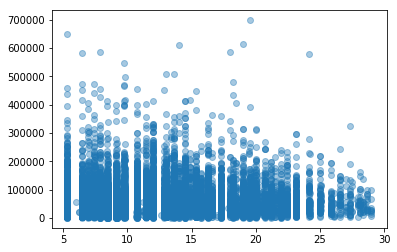

In [7]:
plt.scatter(df.int_rate,df.total_bal_ex_mort,alpha=0.4)

In [8]:
cols2enc = df_filtered.select_dtypes(include=object).columns
labelencoder = LabelEncoder()

for coln in cols2enc:
    form_name = coln+"_enc"
    df_filtered[form_name] = labelencoder.fit_transform(np.array(
                                df_filtered[coln].astype(str).values).reshape(-1,1))
    col_names.append(form_name)
    col_names.remove(coln)

/Users/millenium/anaconda/envs/homework1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/millenium/anaconda/envs/homework1/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [12]:
def run_exp (col_in, df_filtered, y ):
    df_train,df_test, y_train, y_test =  train_test_split(df_filtered[col_in], y,
                                                          test_size=0.20, shuffle = False, random_state=42)
    X_train = df_train.fillna(0).values
    X_test = df_test.fillna(0).values
    xg = GradientBoostingClassifier(n_estimators=100, subsample=0.8,
                                    max_depth=5, learning_rate=0.05 )
    xg.fit(X_train,y_train)
    y_hat_test = xg.predict_proba(X_test)[:,1]
    elem = {"col_in":col_in,"roc":roc_auc_score(y_test,y_hat_test ),"model":xg}
    return elem

In [13]:
rslt = run_exp(col_names, df_filtered.iloc[0:10000,:],df.willGoBad[0:10000])
xg = rslt["model"]
print(rslt["roc"])
proba_data = xg.predict_proba( df_filtered.iloc[10000:,:][col_names].fillna(0).values)
id_data = df.id[10000:]
pd.DataFrame({"ID":id_data , "PROBABILITY": proba_data[:,1]}).to_csv("result.csv", index=False)

0.6762086015220526


In [26]:
xg = run_exp(col_names,df_filtered.iloc[0:10000,:],df.willGoBad[0:10000])["model"]
df_importances = pd.DataFrame(list(zip(col_names,
                                  list(xg.feature_importances_)))
                              ,columns= ["name","value"])
df_importances = df_importances.sort_values("value",ascending=False)
for i in range(1,df_importances.shape[0],1):
    col_in = df_importances["name"].values[:i]
    rst_model = run_exp(col_in,df_filtered.iloc[0:10000,:],df.willGoBad[0:10000])
    print(rst_model["col_in"], rst_model["roc"])

['int_rate'] 0.6794316181135195
['int_rate' 'l3_zip_code_enc'] 0.6678368367155407
['int_rate' 'l3_zip_code_enc' 'avg_cur_bal'] 0.696695487301576
['int_rate' 'l3_zip_code_enc' 'avg_cur_bal' 'mo_sin_old_rev_tl_op'] 0.6794233021842382
['int_rate' 'l3_zip_code_enc' 'avg_cur_bal' 'mo_sin_old_rev_tl_op'
 'tot_hi_cred_lim'] 0.6771257297227944
['int_rate' 'l3_zip_code_enc' 'avg_cur_bal' 'mo_sin_old_rev_tl_op'
 'tot_hi_cred_lim' 'mths_since_recent_bc'] 0.6784443985088351
['int_rate' 'l3_zip_code_enc' 'avg_cur_bal' 'mo_sin_old_rev_tl_op'
 'tot_hi_cred_lim' 'mths_since_recent_bc' 'total_rec_int'] 0.6826736425433437
['int_rate' 'l3_zip_code_enc' 'avg_cur_bal' 'mo_sin_old_rev_tl_op'
 'tot_hi_cred_lim' 'mths_since_recent_bc' 'total_rec_int'
 'total_rec_prncp'] 0.6848262802373128
['int_rate' 'l3_zip_code_enc' 'avg_cur_bal' 'mo_sin_old_rev_tl_op'
 'tot_hi_cred_lim' 'mths_since_recent_bc' 'total_rec_int'
 'total_rec_prncp' 'dti'] 0.6788815787910539
['int_rate' 'l3_zip_code_enc' 'avg_cur_bal' 'mo_sin_ol

['int_rate' 'l3_zip_code_enc' 'avg_cur_bal' 'mo_sin_old_rev_tl_op'
 'tot_hi_cred_lim' 'mths_since_recent_bc' 'total_rec_int'
 'total_rec_prncp' 'dti' 'revol_bal' 'annual_inc' 'mo_sin_old_il_acct'
 'acc_open_past_24mths' 'max_bal_bc' 'out_prncp_inv' 'earlies_credit'
 'bc_open_to_buy' 'addr_state_enc' 'bc_util' 'pct_tl_nvr_dlq' 'revol_util'
 'total_rev_hi_lim' 'open_rv_24m' 'total_acc' 'emp_length_enc'
 'total_bal_ex_mort' 'all_util' 'tot_cur_bal' 'inq_fi' 'total_bc_limit'
 'num_op_rev_tl'] 0.68312983066392
['int_rate' 'l3_zip_code_enc' 'avg_cur_bal' 'mo_sin_old_rev_tl_op'
 'tot_hi_cred_lim' 'mths_since_recent_bc' 'total_rec_int'
 'total_rec_prncp' 'dti' 'revol_bal' 'annual_inc' 'mo_sin_old_il_acct'
 'acc_open_past_24mths' 'max_bal_bc' 'out_prncp_inv' 'earlies_credit'
 'bc_open_to_buy' 'addr_state_enc' 'bc_util' 'pct_tl_nvr_dlq' 'revol_util'
 'total_rev_hi_lim' 'open_rv_24m' 'total_acc' 'emp_length_enc'
 'total_bal_ex_mort' 'all_util' 'tot_cur_bal' 'inq_fi' 'total_bc_limit'
 'num_op_rev_

['int_rate' 'l3_zip_code_enc' 'avg_cur_bal' 'mo_sin_old_rev_tl_op'
 'tot_hi_cred_lim' 'mths_since_recent_bc' 'total_rec_int'
 'total_rec_prncp' 'dti' 'revol_bal' 'annual_inc' 'mo_sin_old_il_acct'
 'acc_open_past_24mths' 'max_bal_bc' 'out_prncp_inv' 'earlies_credit'
 'bc_open_to_buy' 'addr_state_enc' 'bc_util' 'pct_tl_nvr_dlq' 'revol_util'
 'total_rev_hi_lim' 'open_rv_24m' 'total_acc' 'emp_length_enc'
 'total_bal_ex_mort' 'all_util' 'tot_cur_bal' 'inq_fi' 'total_bc_limit'
 'num_op_rev_tl' 'total_cu_tl' 'mo_sin_rcnt_tl' 'installment'
 'mths_since_rcnt_il' 'inq_last_6mths' 'total_bal_il' 'num_rev_accts'
 'num_bc_tl' 'total_rec_late_fee' 'mths_since_recent_inq' 'sub_grade_enc'
 'mo_sin_rcnt_rev_tl_op' 'num_actv_bc_tl' 'out_prncp'] 0.68577667215518
['int_rate' 'l3_zip_code_enc' 'avg_cur_bal' 'mo_sin_old_rev_tl_op'
 'tot_hi_cred_lim' 'mths_since_recent_bc' 'total_rec_int'
 'total_rec_prncp' 'dti' 'revol_bal' 'annual_inc' 'mo_sin_old_il_acct'
 'acc_open_past_24mths' 'max_bal_bc' 'out_prncp_in

['int_rate' 'l3_zip_code_enc' 'avg_cur_bal' 'mo_sin_old_rev_tl_op'
 'tot_hi_cred_lim' 'mths_since_recent_bc' 'total_rec_int'
 'total_rec_prncp' 'dti' 'revol_bal' 'annual_inc' 'mo_sin_old_il_acct'
 'acc_open_past_24mths' 'max_bal_bc' 'out_prncp_inv' 'earlies_credit'
 'bc_open_to_buy' 'addr_state_enc' 'bc_util' 'pct_tl_nvr_dlq' 'revol_util'
 'total_rev_hi_lim' 'open_rv_24m' 'total_acc' 'emp_length_enc'
 'total_bal_ex_mort' 'all_util' 'tot_cur_bal' 'inq_fi' 'total_bc_limit'
 'num_op_rev_tl' 'total_cu_tl' 'mo_sin_rcnt_tl' 'installment'
 'mths_since_rcnt_il' 'inq_last_6mths' 'total_bal_il' 'num_rev_accts'
 'num_bc_tl' 'total_rec_late_fee' 'mths_since_recent_inq' 'sub_grade_enc'
 'mo_sin_rcnt_rev_tl_op' 'num_actv_bc_tl' 'out_prncp' 'last_pymnt_amnt'
 'num_il_tl' 'tot_coll_amt' 'num_tl_op_past_12m' 'num_bc_sats'
 'total_il_high_credit_limit' 'il_util' 'num_rev_tl_bal_gt_0'
 'num_tl_90g_dpd_24m' 'mort_acc'] 0.6922250813179086
['int_rate' 'l3_zip_code_enc' 'avg_cur_bal' 'mo_sin_old_rev_tl_op'
 

['int_rate' 'l3_zip_code_enc' 'avg_cur_bal' 'mo_sin_old_rev_tl_op'
 'tot_hi_cred_lim' 'mths_since_recent_bc' 'total_rec_int'
 'total_rec_prncp' 'dti' 'revol_bal' 'annual_inc' 'mo_sin_old_il_acct'
 'acc_open_past_24mths' 'max_bal_bc' 'out_prncp_inv' 'earlies_credit'
 'bc_open_to_buy' 'addr_state_enc' 'bc_util' 'pct_tl_nvr_dlq' 'revol_util'
 'total_rev_hi_lim' 'open_rv_24m' 'total_acc' 'emp_length_enc'
 'total_bal_ex_mort' 'all_util' 'tot_cur_bal' 'inq_fi' 'total_bc_limit'
 'num_op_rev_tl' 'total_cu_tl' 'mo_sin_rcnt_tl' 'installment'
 'mths_since_rcnt_il' 'inq_last_6mths' 'total_bal_il' 'num_rev_accts'
 'num_bc_tl' 'total_rec_late_fee' 'mths_since_recent_inq' 'sub_grade_enc'
 'mo_sin_rcnt_rev_tl_op' 'num_actv_bc_tl' 'out_prncp' 'last_pymnt_amnt'
 'num_il_tl' 'tot_coll_amt' 'num_tl_op_past_12m' 'num_bc_sats'
 'total_il_high_credit_limit' 'il_util' 'num_rev_tl_bal_gt_0'
 'num_tl_90g_dpd_24m' 'mort_acc' 'open_acc_6m' 'open_il_6m' 'pub_rec'
 'delinq_2yrs' 'inq_last_12m' 'num_accts_ever_120_p

['int_rate' 'l3_zip_code_enc' 'avg_cur_bal' 'mo_sin_old_rev_tl_op'
 'tot_hi_cred_lim' 'mths_since_recent_bc' 'total_rec_int'
 'total_rec_prncp' 'dti' 'revol_bal' 'annual_inc' 'mo_sin_old_il_acct'
 'acc_open_past_24mths' 'max_bal_bc' 'out_prncp_inv' 'earlies_credit'
 'bc_open_to_buy' 'addr_state_enc' 'bc_util' 'pct_tl_nvr_dlq' 'revol_util'
 'total_rev_hi_lim' 'open_rv_24m' 'total_acc' 'emp_length_enc'
 'total_bal_ex_mort' 'all_util' 'tot_cur_bal' 'inq_fi' 'total_bc_limit'
 'num_op_rev_tl' 'total_cu_tl' 'mo_sin_rcnt_tl' 'installment'
 'mths_since_rcnt_il' 'inq_last_6mths' 'total_bal_il' 'num_rev_accts'
 'num_bc_tl' 'total_rec_late_fee' 'mths_since_recent_inq' 'sub_grade_enc'
 'mo_sin_rcnt_rev_tl_op' 'num_actv_bc_tl' 'out_prncp' 'last_pymnt_amnt'
 'num_il_tl' 'tot_coll_amt' 'num_tl_op_past_12m' 'num_bc_sats'
 'total_il_high_credit_limit' 'il_util' 'num_rev_tl_bal_gt_0'
 'num_tl_90g_dpd_24m' 'mort_acc' 'open_acc_6m' 'open_il_6m' 'pub_rec'
 'delinq_2yrs' 'inq_last_12m' 'num_accts_ever_120_p

KeyboardInterrupt: 

In [61]:
col_name_fil = col_names


df_train,df_test, y_train, y_test =  train_test_split(df_filtered.iloc[0:10000,:][col_name_fil],
                                                      df.willGoBad[0:10000],
                                                      test_size=0.20, shuffle = False, random_state=42)
X_train = df_train.fillna(0).values
X_test = df_test.fillna(0).values

xg = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight="balanced" )
xg.fit(X_train,y_train)
print('Train', roc_auc_score(y_train,xg.predict_proba(X_train)[:,1] ))
y_hat_test = xg.predict_proba(X_test)[:,1]
print('Test', roc_auc_score(y_test,y_hat_test ))

Train 0.7763691000270034
Test 0.7003580601550565


In [68]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 400, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 40 , 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [4,5,6, 10, 20, 30, 40, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 8],
 'min_samples_split': [2, 5, 10, 20],
 'n_estimators': [100 , 200, 300]}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=2,
                               random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)

{'n_estimators': [100, 133, 166, 200, 233, 266, 300, 333, 366, 400], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10, 20, 40, 100], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=266, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False 
[CV] n_estimators=266, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False 
[CV] n_estimators=266, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False 
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, total=   3.4s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_featur

[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=110, bootstrap=True 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=110, bootstrap=True, total=   9.6s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=110, bootstrap=True 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=110, bootstrap=True, total=   9.8s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True 
[CV]  n_estimators=333, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, total=  14.3s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min


[CV]  n_estimators=333, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, total=  13.7s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=110, bootstrap=True, total=   9.5s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True, total=   6.5s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True, total=   6.4s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False 
[CV]  n_estimators=200, m

[CV] n_estimators=233, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=166, min_samples_split=20, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True, total=   4.9s
[CV] n_estimators=333, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=233, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True, total=   7.5s
[CV] n_estimators=333, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=233, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True, total=   7.7s
[CV] n_estimators=333, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=233, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True, total=   7.3s
[CV] n_estimators=100,

[CV] n_estimators=100, min_samples_split=40, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=True 
[CV]  n_estimators=333, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=80, bootstrap=False, total=  17.6s
[CV] n_estimators=100, min_samples_split=40, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=40, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=True, total=   2.8s
[CV] n_estimators=100, min_samples_split=40, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=40, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=True, total=   2.9s
[CV] n_estimators=400, min_samples_split=100, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=40, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=True, total=   2.8s
[CV] n_estimators=40

[CV]  n_estimators=400, min_samples_split=20, min_samples_leaf=1, max_features=auto, max_depth=60, bootstrap=True, total=  13.1s
[CV] n_estimators=333, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=20, min_samples_leaf=1, max_features=auto, max_depth=60, bootstrap=True, total=  12.6s
[CV] n_estimators=333, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=20, min_samples_leaf=1, max_features=auto, max_depth=60, bootstrap=True, total=  13.2s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=True, total=   3.0s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=True 
[CV]  n_estimators=333, min_

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.6min


[CV]  n_estimators=266, min_samples_split=20, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True, total=   7.1s
[CV] n_estimators=233, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=70, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False, total=   5.2s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False 
[CV]  n_estimators=233, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=70, bootstrap=True, total=   7.5s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False 
[CV]  n_estimators=233, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=70, bootstrap=True, total=   7.5s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False 
[CV]  n_estimators=233, min_

[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=366, min_samples_split=20, min_samples_leaf=4, max_features=sqrt, max_depth=110, bootstrap=False, total=  15.8s
[CV] n_estimators=233, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=366, min_samples_split=20, min_samples_leaf=4, max_features=sqrt, max_depth=110, bootstrap=False, total=  14.5s
[CV] n_estimators=233, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=233, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True, total=   6.9s
[CV] n_estimators=233, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False, total=   8.6s
[CV] n_estimators=233, min_s

[CV] n_estimators=333, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False 
[CV]  n_estimators=333, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=90, bootstrap=True, total=   9.3s
[CV] n_estimators=333, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False 
[CV]  n_estimators=333, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=90, bootstrap=True, total=   9.4s
[CV] n_estimators=333, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False 
[CV]  n_estimators=333, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=90, bootstrap=True, total=   9.1s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=333, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False, total=  14.4s
[CV] n_estimators=400, min_sam

[CV]  n_estimators=266, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=False, total=  11.8s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=100, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False, total=   8.0s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=100, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False, total=   7.6s
[CV] n_estimators=166, min_samples_split=100, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=True, total=   9.6s
[CV] n_estimators=166, min_samples_split=100, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=

[CV]  n_estimators=100, min_samples_split=40, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=False, total=   4.7s
[CV] n_estimators=100, min_samples_split=40, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=40, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=False, total=   4.8s
[CV] n_estimators=400, min_samples_split=100, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=40, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=False, total=   4.4s
[CV] n_estimators=400, min_samples_split=100, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False 
[CV]  n_estimators=366, min_samples_split=100, min_samples_leaf=1, max_features=auto, max_depth=70, bootstrap=False, total=  14.9s
[CV] n_estimators=400, min_samples_split=100, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False 
[CV]  n_estimato

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 12.6min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [100, 133, 166, 200, 233, 266, 300, 333, 366, 400], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10, 20, 40, 100], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [69]:
rf_random.grid_scores_

/Users/millenium/anaconda/envs/homework1/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.86662, std: 0.00059, params: {'n_estimators': 266, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': False},
 mean: 0.86638, std: 0.00066, params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False},
 mean: 0.86675, std: 0.00013, params: {'n_estimators': 166, 'min_samples_split': 40, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True},
 mean: 0.86650, std: 0.00031, params: {'n_estimators': 233, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True},
 mean: 0.86675, std: 0.00013, params: {'n_estimators': 366, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True},
 mean: 0.86662, std: 0.00016, params: {'n_estimators': 166, 'min_samples_split': 100, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 70, 'bo

In [44]:
col_name_fil = ['int_rate' ,'l3_zip_code_enc', 'avg_cur_bal']


df_train,df_test, y_train, y_test =  train_test_split(df_filtered.iloc[0:10000,:][col_name_fil],
                                                      df.willGoBad[0:10000],
                                                      test_size=0.20, shuffle = False, random_state=42)
X_train = df_train.fillna(0).values
X_test = df_test.fillna(0).values

xg = GradientBoostingClassifier(n_estimators=100,subsample=0.7, max_depth=4, learning_rate=0.1 )
xg.fit(X_train,y_train)
print('Train', roc_auc_score(y_train,xg.predict_proba(X_train)[:,1] ))
y_hat_test = xg.predict_proba(X_test)[:,1]
print('Test', roc_auc_score(y_test,y_hat_test ))

Train 0.8134816151860127
Test 0.682596423200017


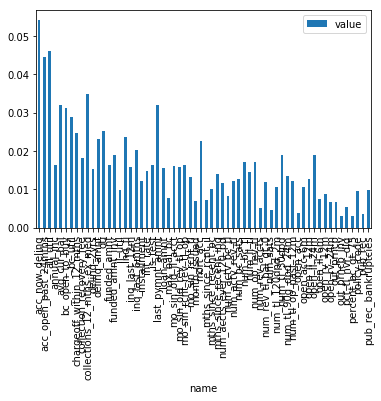

In [31]:
df_importances = pd.DataFrame(list(zip(col_names,list(xg.feature_importances_)))
                                   ,columns= ["name","value"])
df_importances.sort_values("value")
df_importances = df_importances.set_index(df_importances.name)
df_importances[["value"]].plot.bar()

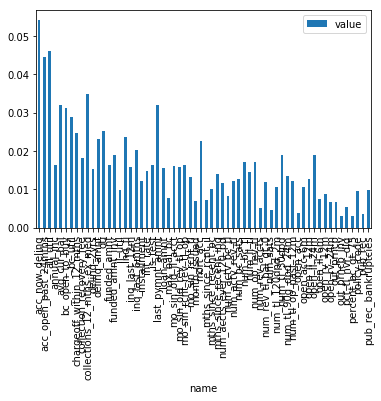

In [32]:
df_importances = pd.DataFrame(list(zip(col_names,list(xg.feature_importances_))),columns= ["name","value"])
df_importances.sort_values("value")
df_importances = df_importances.set_index(df_importances.name)
df_importances[["value"]].plot.bar()

### Logistic Regression
No dummy variables

In [37]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

df_train,df_test, y_train, y_test = train_test_split(df_filtered.iloc[0:10000,:][col_names],
                                                      df.willGoBad[0:10000],
                                                      test_size=0.20, shuffle = False, random_state=42)
X_train = df_train.fillna(0).values
X_test = df_test.fillna(0).values

clf = LogisticRegression(penalty='l2', C=0.1  ).fit(X_train,y_train)
y_hat_test = clf.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test,y_hat_test ))
proba_data = clf.predict_proba( df_filtered.iloc[10000:,:][col_names].fillna(0).values)
id_data = df.id[10000:]
pd.DataFrame({"ID":id_data , "PROBABILITY": proba_data[:,1]}).to_csv("result_l.csv", index=False)

0.694610565031755


In [38]:
sorted(list(zip(*clf.coef_, col_names)), key= lambda x: x[0], reverse=True)

[(0.003514993319344688, 'installment'),
 (0.001204383438317803, 'sub_grade_enc'),
 (0.001176034703425736, 'acc_open_past_24mths'),
 (0.0009588965357261549, 'num_rev_accts'),
 (0.0009126184341707296, 'open_rv_24m'),
 (0.0008569058498609485, 'int_rate'),
 (0.0007912634273599958, 'total_acc'),
 (0.0007477143147338825, 'num_op_rev_tl'),
 (0.0006722990586794645, 'total_rec_late_fee'),
 (0.0006592926111245926, 'out_prncp'),
 (0.0006386052676866493, 'percent_bc_gt_75'),
 (0.000616773063430651, 'num_bc_tl'),
 (0.0005265643258912059, 'num_actv_rev_tl'),
 (0.0005181125734638766, 'num_sats'),
 (0.0005144026563490271, 'open_acc'),
 (0.0005009038184059509, 'num_rev_tl_bal_gt_0'),
 (0.0004980620455201154, 'num_tl_op_past_12m'),
 (0.0004912870705743163, 'il_util'),
 (0.00045565548246837386, 'bc_util'),
 (0.0004548889833275925, 'num_bc_sats'),
 (0.0004253987782921658, 'inq_last_12m'),
 (0.0004130985862578379, 'funded_amnt'),
 (0.0004130985862578379, 'loan_amnt'),
 (0.0003835482951769455, 'acct_age'),


In [43]:
df_dum = df_filtered[col_names_or]
dum_cols = df_dum.select_dtypes(include=object).columns
print(dum_cols)
df_filtered_with_dummies = pd.get_dummies(df_dum, prefix='c_', columns=dum_cols)

df_train,df_test, y_train, y_test =  train_test_split(
    df_filtered_with_dummies[:10000], df.willGoBad[:10000],
            test_size=0.20, shuffle = False, random_state=42)
X_train = df_train.fillna(0).values
X_test = df_test.fillna(0).values

clf = LogisticRegression(penalty='l2', C=0.1  ).fit(X_train,y_train)
y_hat_test = clf.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test,y_hat_test ))
importance_data = zip(*clf.coef_, df_filtered_with_dummies.columns)
sorted(importance_data, key=lambda x: x[0], reverse=True)

Index(['addr_state', 'application_type', 'emp_length', 'grade',
       'home_ownership', 'initial_list_status', 'loan_status', 'purpose',
       'pymnt_plan', 'sub_grade', 'term', 'title', 'verification_status',
       'l3_zip_code'],
      dtype='object')
0.694052209780008


[(0.0037794752656618406, 'installment'),
 (0.001883716168028789, 'acc_open_past_24mths'),
 (0.0015233728679953673, 'num_rev_accts'),
 (0.0014578518777008157, 'open_rv_24m'),
 (0.0014140077420113234, 'int_rate'),
 (0.0012048298628744459, 'total_acc'),
 (0.001184940923841324, 'num_op_rev_tl'),
 (0.0011491863380836854, 'total_rec_late_fee'),
 (0.001087797211862448, 'acct_age'),
 (0.0009911930134381577, 'num_bc_tl'),
 (0.0008874382081567119, 'percent_bc_gt_75'),
 (0.0008305689380923083, 'num_actv_rev_tl'),
 (0.0007881932115923624, 'num_rev_tl_bal_gt_0'),
 (0.0007864847177859343, 'num_sats'),
 (0.0007818857499700466, 'num_tl_op_past_12m'),
 (0.0007799621856321965, 'open_acc'),
 (0.000728615142187572, 'num_bc_sats'),
 (0.0007166133007337177, 'out_prncp'),
 (0.0006894243777679619, 'inq_last_12m'),
 (0.0006203950098897908, 'bc_util'),
 (0.0005795802430547083, 'open_rv_12m'),
 (0.0004861954354395612, 'total_pymnt'),
 (0.00045690410509675644, 'num_actv_bc_tl'),
 (0.00044443248410924193, 'open_il